(1, 200)


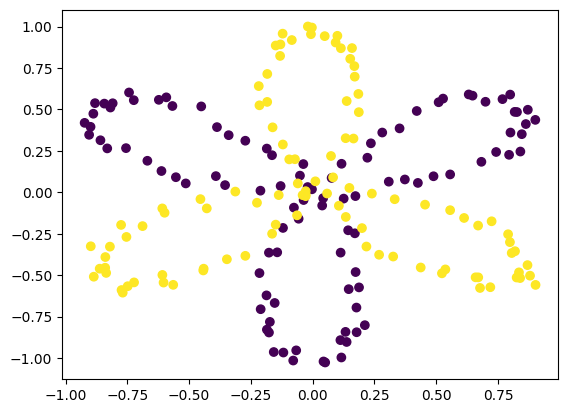

In [333]:
import numpy as np 
import matplotlib.pyplot as plt

# Constructing dataset
m_train = 200

theta = np.linspace(0, 2 * np.pi, m_train)
r = []
for t in theta:
    if t < np.pi:
        r.append(np.sin(3 * t))
    else:
        r.append(-np.sin(3 * t))

r = np.array(r)

np.random.seed(69)
X = np.random.uniform(-0.05, 0.05, (2, m_train))  # two rows, one for each feature
X[0, :] += r * np.cos(theta)
X[1, :] += r * np.sin(theta)

Y = np.where(theta < np.pi, 0, 1).reshape(1, -1)

# Plotting
plt.scatter(X[0, :], X[1, :], c=Y)
plt.show()

### Defining and initialising neural network structure

Our neural net is gonna have:
- two inputs
- four hidden layer nodes
- single output layer node

In [334]:
def init_nn(n_x, n_h, n_y):  # n_ => size
    np.random.seed(69)

    W1 = np.random.uniform(-0.01, 0.01, (n_h, n_x))
    b1 = np.zeros((n_h, 1))
    W2 = np.random.uniform(-0.01, 0.01, (n_y, n_h))
    b2 = np.zeros((n_y, 1))

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }

    return parameters

In [335]:
def layer_sizes(X, Y):
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    
    return (n_x, n_h, n_y)

### The loop

In [336]:
# Activation function for first layer
def g1(z):
    return np.tanh(z)

def g2(z):
    return 1 / (1 + np.exp(-z))

In [337]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = g1(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = g2(Z2)

    # will be used in backpropogation
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    } 

    return A2, cache

In [338]:
def calc_cost(A2, Y, parameters):
    m = Y.shape[1]
    logprobs = (Y * np.log(A2)) + ((1-Y) * np.log(1-A2))
    cost = (-1/m) * np.sum(logprobs)
    cost = float(np.squeeze(cost))  # fixes dimentions

    return cost  # a scaler

In [339]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }
    
    return grads

In [340]:
def update_parameters(parameters, grads, learning_rate):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    
    return parameters

# Integrating all the above:

In [341]:
def nn_model(X, Y, n_h, learning_rate, num_iterations = 10000, print_cost=False):
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = init_nn(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Gradient descent
    for i in range(0, num_iterations):
        # Forward propagation
        A2, cache = forward_propagation(X, parameters)
        # cache === {Z1, A1, Z2, A2}

        # Cost function
        cost = calc_cost(A2, Y, parameters)

        # Backpropagation
        grads = backward_propagation(parameters, cache, X, Y)

        # Update rule for each parameter
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost==True and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    return parameters

# Final execution

In [342]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    
    return predictions

In [343]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
    y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)


Accuracy for 1 hidden units: 62.5 %
Accuracy for 2 hidden units: 74.0 %
Accuracy for 3 hidden units: 91.5 %
Accuracy for 4 hidden units: 91.5 %
Accuracy for 5 hidden units: 91.5 %
Accuracy for 20 hidden units: 92.0 %
Accuracy for 50 hidden units: 48.5 %


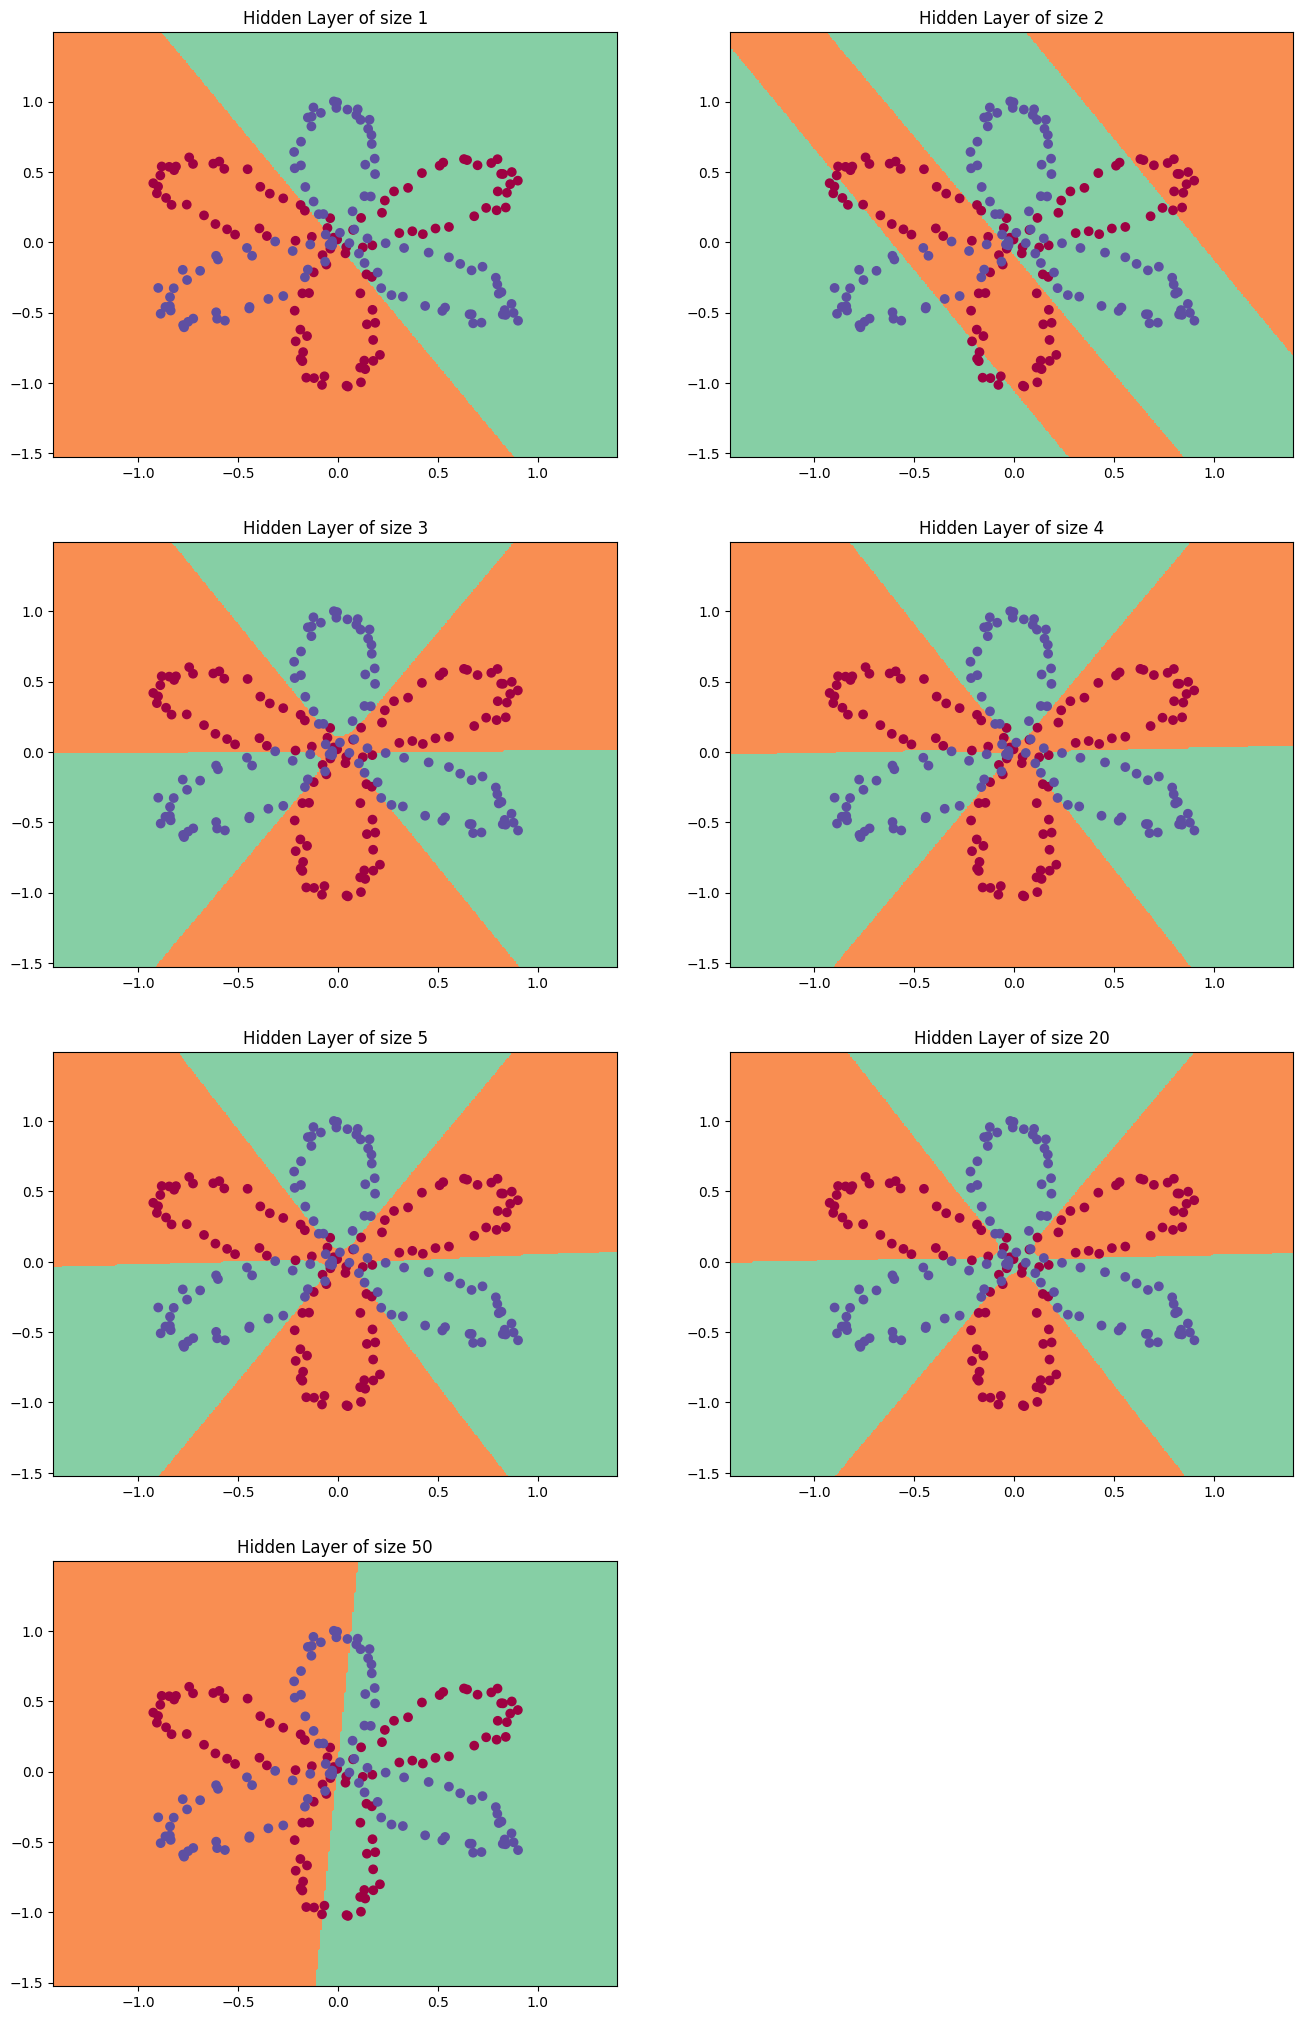

In [354]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, learning_rate=1.2, num_iterations = 10_000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))